# 🧠 Customer Churn Prediction: A Machine Learning Approach

**Goal:** Predict whether a customer will churn based on demographic, account, and service usage features.

**Dataset:** [Telco Customer Churn Dataset](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)  
**Tools:** Python, scikit-learn, XGBoost, SHAP, SMOTE  




In [18]:
# Importing Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install shap scikit-learn xgboost imbalanced-learn


#Modeling & preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

#Interpretability
import shap
import warnings
warnings.filterwarnings("ignore")





In [19]:
# Uploading and load the dataset
from google.colab import files
uploaded = files.upload()

# Read CSV into a pandas dataframe
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()



Saving Telco-Customer-Churn.csv to Telco-Customer-Churn (1).csv


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [20]:
# Converting TotalCharges to numeric and handling missing
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

#Droping rows with missing TotalCharges
df.dropna(inplace=True)
df.drop('customerID', axis=1, inplace=True)

# Converting churn column to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Spliting numerical and categorical columns
cat_cols = df.select_dtypes(include='object').columns
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# One-hot encoding
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Scale numeric
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [21]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Balancing the training set with SMOTE technique
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


In [22]:
# Training 3 different models and comparing their performance (Logistic Regression,Random Forest, XGBoost )
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    print(f"\n📘 {name}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))



📘 Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1549
           1       0.53      0.72      0.61       561

    accuracy                           0.75      2110
   macro avg       0.71      0.74      0.71      2110
weighted avg       0.79      0.75      0.76      2110

Confusion Matrix:
[[1183  366]
 [ 155  406]]

📘 Random Forest
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1549
           1       0.55      0.62      0.58       561

    accuracy                           0.76      2110
   macro avg       0.70      0.72      0.71      2110
weighted avg       0.77      0.76      0.77      2110

Confusion Matrix:
[[1260  289]
 [ 214  347]]

📘 XGBoost
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1549
           1       0.54      0.63      0.58       561

    accuracy                           0.


📘 Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1549
           1       0.53      0.72      0.61       561

    accuracy                           0.75      2110
   macro avg       0.71      0.74      0.71      2110
weighted avg       0.79      0.75      0.76      2110



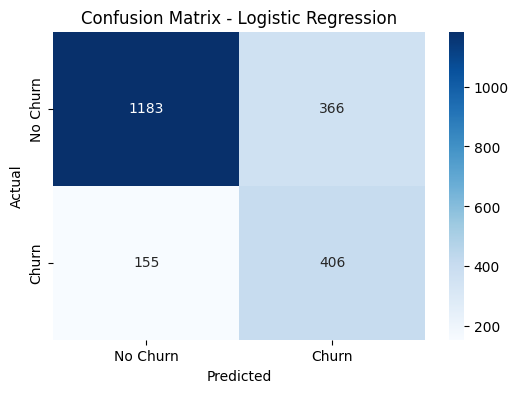


📘 Random Forest
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1549
           1       0.55      0.62      0.58       561

    accuracy                           0.76      2110
   macro avg       0.70      0.72      0.71      2110
weighted avg       0.77      0.76      0.77      2110



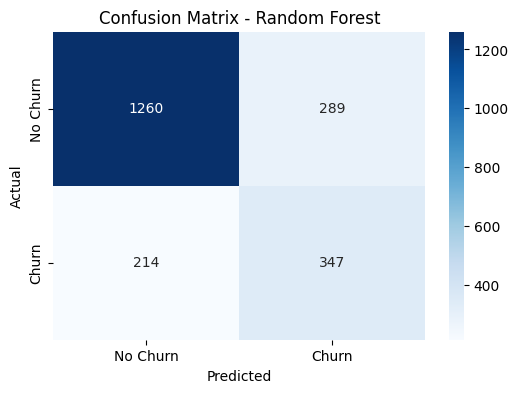


📘 XGBoost
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1549
           1       0.54      0.63      0.58       561

    accuracy                           0.76      2110
   macro avg       0.70      0.72      0.70      2110
weighted avg       0.77      0.76      0.76      2110



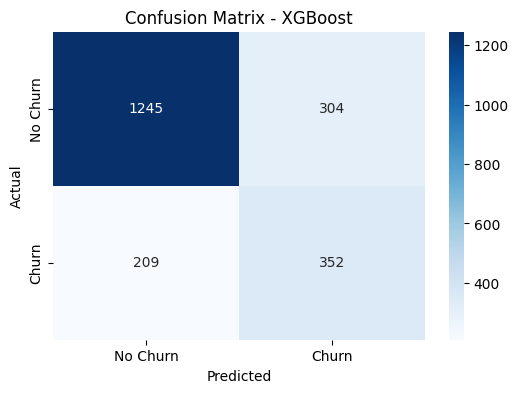

In [23]:


for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    print(f"\n📘 {name}")
    print(classification_report(y_test, y_pred))

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

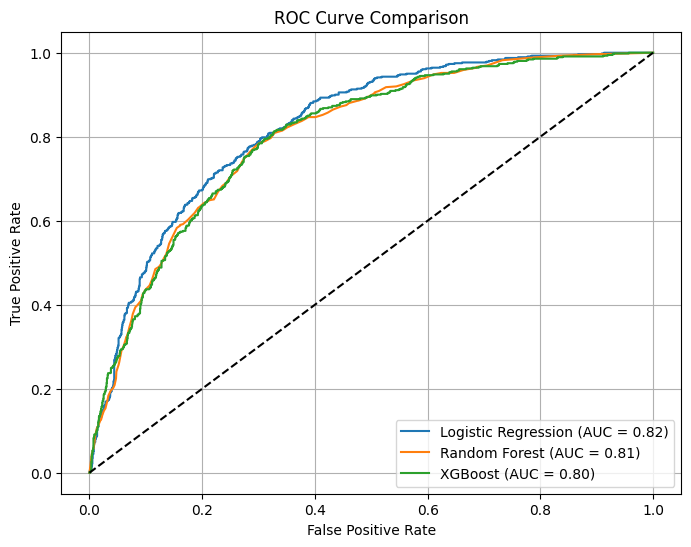

In [24]:
# Plotting ROC curves for all models

plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()


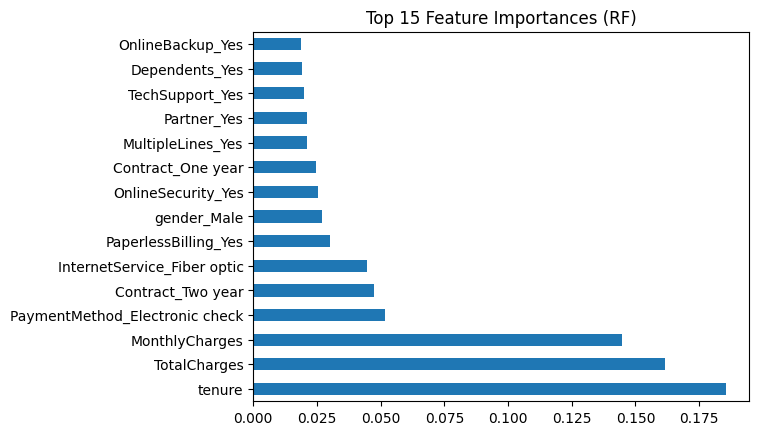

In [25]:
#Plotting top 15 feature importances from Random Forest
feat_imp = pd.Series(models['Random Forest'].feature_importances_, index=X.columns)
feat_imp.nlargest(15).plot(kind='barh')
plt.title("Top 15 Feature Importances (RF)")
plt.show()


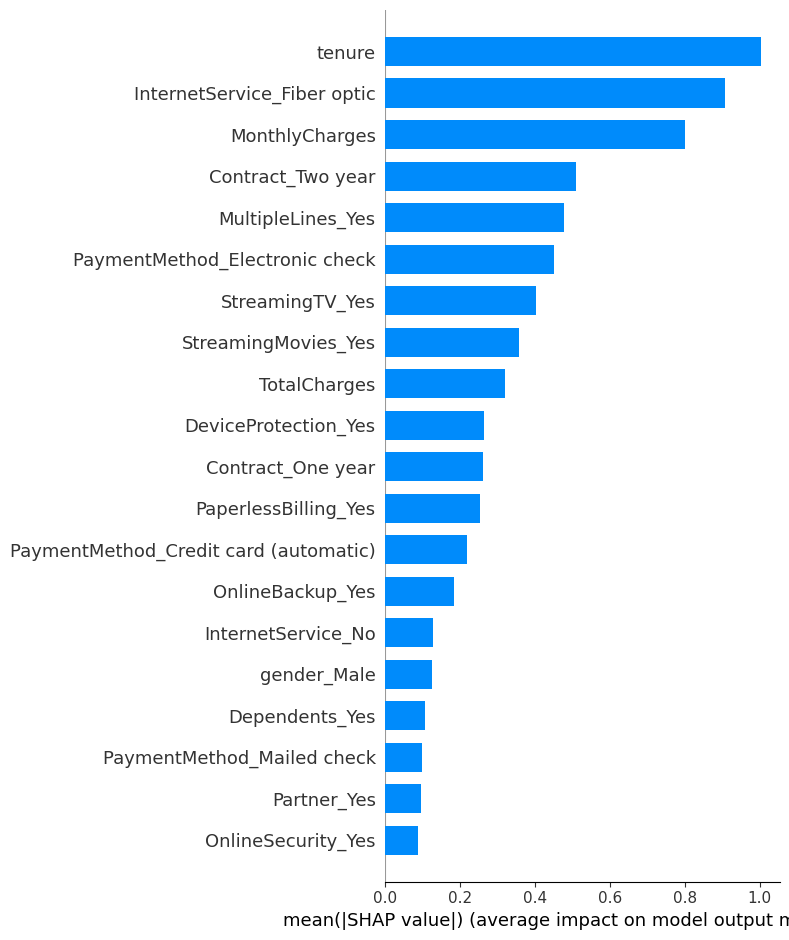

In [26]:
# SHAP summary plot for XGBoost
explainer = shap.Explainer(models['XGBoost'])
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


In [27]:
# Checking model recall across subgroups (e.g., SeniorCitizen)
X_test_copy = X_test.copy()
X_test_copy['SeniorCitizen'] = df.loc[X_test_copy.index, 'SeniorCitizen']
y_pred_rf = models['Random Forest'].predict(X_test)

from sklearn.metrics import recall_score
for group in [0, 1]:
    idx = X_test_copy['SeniorCitizen'] == group
    group_recall = recall_score(y_test[idx], y_pred_rf[idx])
    print(f"Recall for SeniorCitizen = {group}: {group_recall:.2f}")

Recall for SeniorCitizen = 0: 0.59
Recall for SeniorCitizen = 1: 0.70
